In [2]:
import pandas as pd
pd.options.mode.chained_assignment = None
import math
import numpy as np
import seaborn as sns
from collections import OrderedDict
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.patheffects as path_effects


markerSize = 6
lineWidth = 2

performanceColors = ["#CF597E", "#56ba23", "#089099"]
performanceColorMap = list(map(lambda x: sns.desaturate(x,1),performanceColors))
sns.set_palette(performanceColorMap)
sns.color_palette()

percentageColors = ["#1b2433", "#475570", "#a1233c", "#D66853" ]# Set your custom color palette
percentageColorMap = list(map(lambda x: sns.desaturate(x,1),percentageColors))
sns.set_palette(percentageColorMap)
sns.color_palette() 

[(0.10588235294117647, 0.1411764705882353, 0.2),
 (0.2784313725490196, 0.3333333333333333, 0.4392156862745098),
 (0.6313725490196078, 0.13725490196078433, 0.23529411764705882),
 (0.8392156862745098, 0.40784313725490196, 0.3254901960784314)]

In [3]:
def readLogFile(filename):
    df = pd.read_csv(filename, header=0, delimiter=',')
    return df.sort_values(by=['M','N','K'])

def groupByAverage(df):
    result = df.groupby(['Algo', 'M', 'N', 'K', 'TotalGPUs', 'DataLocation']).mean().reset_index()
    return result

def filterNumberOfDevices(df, numDevices):
    return df[df['TotalGPUs'] == numDevices]

def filterStackSize(df, stackSize):
    return df[df['StackSize'] == stackSize]

def filterProcessorGrid(df, dRow, dCol, stackSize):
    return df[(df['StackSize'] == stackSize) & (df['dRow'] == dRow) & (df['dCol'] == dCol)]


def squareDatasetLimits(df, lowerLimit, upperLimit):
    return df[
        ((df['M']*df['N']*df['K'] > lowerLimit**3)) &
        ((df['M']*df['N']*df['K'] < upperLimit**3)) &
        (df['M'] == df['N']) & (df['K'] == df['M'])
    ]

In [4]:
pd.set_option('display.max_rows', None)
dataset = pd.DataFrame()

cannon25d = readLogFile("executionAnalysis/DGEMM_execution_logs-PreDistributed_GEMM-meluxina-2.5DCANNON-cuBLAS.csv")
cannon25d['Algo'] = cannon25d['Algo']+ "-MPI" 
cannon25d['PlotOrder'] = 1
dataset = pd.concat([dataset, cannon25d])

cannon25d_nccl = readLogFile("executionAnalysis/DGEMM_execution_logs-PreDistributed_GEMM-meluxina-2.5DCANNON-cuBLAS-NCCL.csv")
cannon25d_nccl['PlotOrder'] = 2
dataset = pd.concat([dataset, cannon25d_nccl])

dataset = squareDatasetLimits(dataset, 8191, 50000)
dataset = groupByAverage(dataset)
dataset['TotalTime'] = dataset['CommunicationTime'] + dataset['GemmCallTime']
dataset['CommunicationPercentage'] = dataset['CommunicationTime'] / dataset['TotalTime']
dataset['ComputationPercentage'] = dataset['GemmCallTime'] / dataset['TotalTime']

dataset['Performance (Tflops)'] = dataset['GFlops'] / 1024
dataset.sort_values(inplace=True, by='PlotOrder')
dataset.to_csv("test.csv")

In [5]:
# Font sizes
font=8
#plt.rc('font', family='serif', serif='Times') #annoying warning filling my view, so disabled until needed
#plt.rc('text', usetex=True)
plt.rc('xtick', labelsize=font)
plt.rc('ytick', labelsize=font)
plt.rc('axes', labelsize=font)
plt.rc('figure', titlesize=font)
# width as measured in inkscape
width = 3.487
height = width / 1.618

[<matplotlib.patches.Rectangle object at 0x7f74c9162320>, <matplotlib.patches.Rectangle object at 0x7f74c9162fb0>, <matplotlib.patches.Rectangle object at 0x7f74c70d9d50>, <matplotlib.patches.Rectangle object at 0x7f74c7099600>] ['2.5D CANNON cuBLAS-MPI', '2.5D CANNON cuBLAS NCCL', '2.5D CANNON cuBLAS-MPI', '2.5D CANNON cuBLAS NCCL']


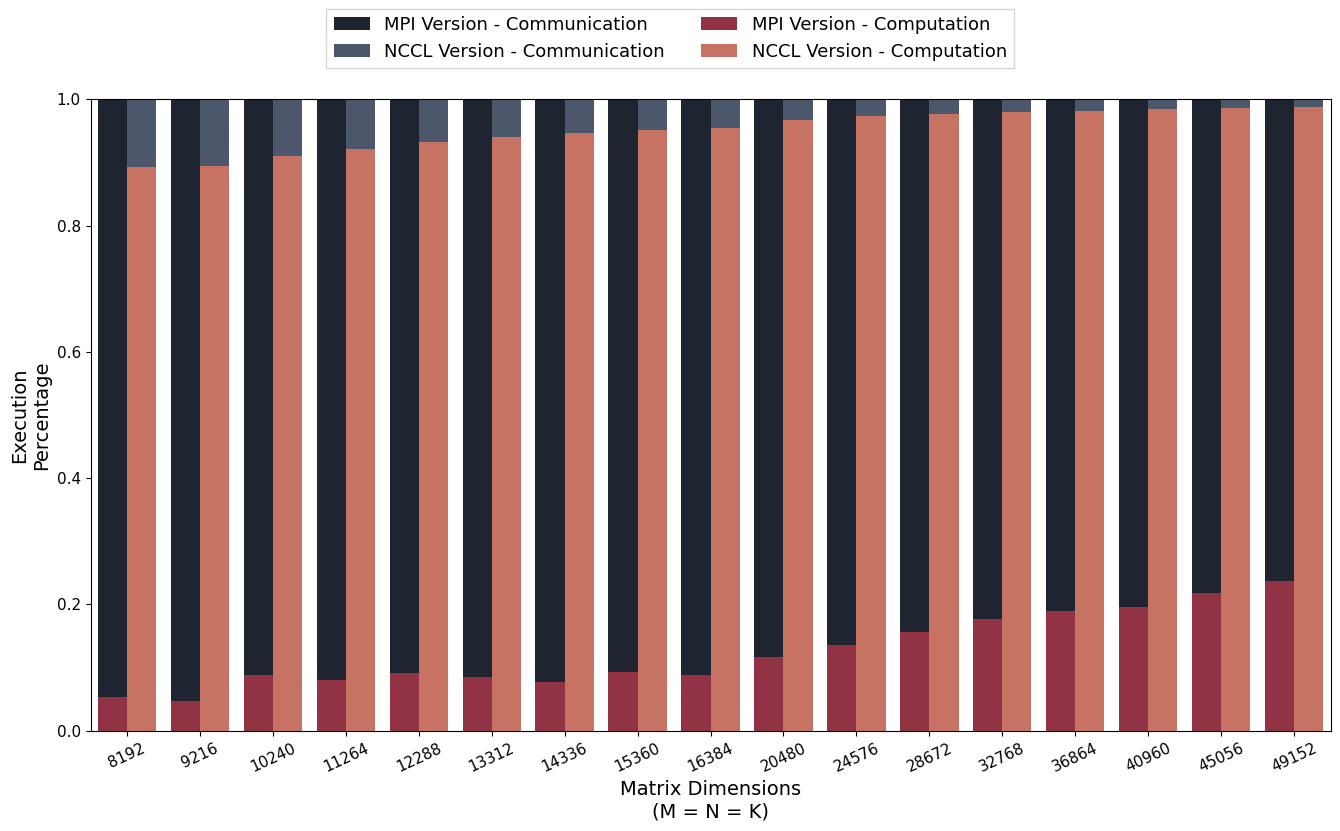

In [6]:
fig, ax = plt.subplots(figsize=(16,8.2))

sns.set_palette(percentageColorMap)
commBar = sns.barplot(data=filterProcessorGrid(dataset, 2, 2, 1), x='M', y=1, hue='Algo')

sns.set_palette(percentageColorMap[2:])
compBar = sns.barplot(data=filterProcessorGrid(dataset, 2, 2, 1), x='M', y='ComputationPercentage', hue='Algo')

ax.set_ylim([0,1])
handles, labels = plt.gca().get_legend_handles_labels()
print(handles, labels)
new_labels= ["MPI Version - Communication", "NCCL Version - Communication",
            "MPI Version - Computation", "NCCL Version - Computation"]
fig.legend(handles=handles, labels=new_labels, loc = 'upper center', fontsize = 13, fancybox = False, ncol = 2)
ax.get_legend().remove()
plt.xticks(rotation=25)
ax.tick_params(labelsize=11)
plt.ylabel("Execution\nPercentage", fontsize=14)
plt.xlabel("Matrix Dimensions\n(M = N = K)", fontsize=14)
systemName="meluxina"
fig.savefig(f'plots/{systemName}-PreDistributed-DGEMM-2.5DCannon-MPI_vs_NCCL.png')

In [7]:
#--------------------- Plot communication speedup --------------------------#

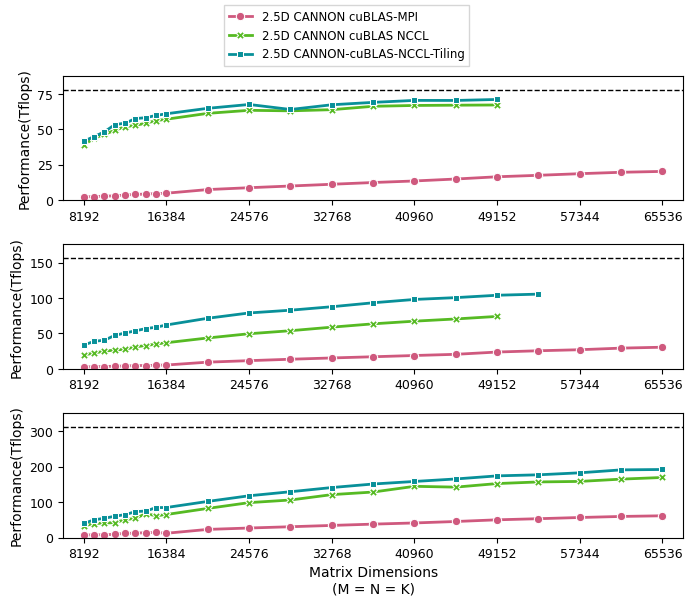

In [10]:
#------------- SIMPLE PERFORMANCE/ SOTA COMPARISON PLOT  --------------------#

performanceDataset = pd.DataFrame()

cannon25d_nccl_tiling = readLogFile("performanceComparison/DGEMM_execution_logs-PreDistributed_GEMM-meluxina-2.5DCANNON-cuBLAS-NCCL-wTiling.csv")
cannon25d['PlotOrder'] = 1
cannon25d_nccl['PlotOrder'] = 2
cannon25d_nccl_tiling['PlotOrder'] = 3

cannon221 = cannon25d[cannon25d['TotalGPUs'] == 4] 
cannon221['GFlops'] = cannon221['GFlops']*3
cannon221['TotalGPUs'] = 16
cannon221['dRow'] = 4
cannon221['dCol'] = 4

performanceDataset = pd.concat([performanceDataset, cannon25d])
performanceDataset = pd.concat([performanceDataset, cannon221])
performanceDataset = pd.concat([performanceDataset, cannon25d_nccl])
performanceDataset = pd.concat([performanceDataset, cannon25d_nccl_tiling])

performanceDataset = squareDatasetLimits(performanceDataset, 8191, 65537)
performanceDataset = groupByAverage(performanceDataset)
performanceDataset['Performance (Tflops)'] = performanceDataset['GFlops'] / 1024
performanceDataset.sort_values(inplace=True, by = ['PlotOrder'])

sns.set_palette(performanceColors)
fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(8,6))
sns.lineplot(data=filterNumberOfDevices(performanceDataset, 4), x='M', y = 'Performance (Tflops)', hue='Algo', style='Algo', markers=True,ax=axes[0], marker = 'o', markersize = markerSize, linewidth = lineWidth, dashes=False)
sns.lineplot(data=filterNumberOfDevices(performanceDataset, 8), x='M', y = 'Performance (Tflops)', hue='Algo', style='Algo', markers=True, ax=axes[1], marker = 'o', markersize = markerSize, linewidth = lineWidth, legend=False, dashes=False)
sns.lineplot(data=filterNumberOfDevices(performanceDataset, 16), x='M', y = 'Performance (Tflops)', hue='Algo', style='Algo', markers=True, ax=axes[2], marker = 'o', markersize = markerSize, linewidth = lineWidth, legend=False, dashes=False)

for ax, numDevs in zip(axes, [4,8,16]):
    ax.axhline(y = 19.5*numDevs, color = 'k', linestyle = '--', linewidth = 1)
    ax.set_ylim([0, numDevs*19.5 + 10*(numDevs/4)])
    ax.set_ylabel("Performance(Tflops)", fontsize=10)
    # ax.set_title(f'Number Of Nodes: {int(numDevs/4)}', fontsize=7)
    ax.set_xlabel('')
    ax.set_xlim([4096+2048, 2**16+2048])
    ax.set_xticks([8192+x*8192 for x in range(0,8)])
    ax.tick_params(labelsize=9)

axes[0].get_legend().remove()
plt.subplots_adjust(hspace=0.35)
axes[2].set_xlabel('Matrix Dimensions\n(M = N = K)', fontsize=10)
fig.legend(loc = 'upper center', fontsize = 8.5, fancybox = False, ncol = 1)
systemName="meluxina"
fig.savefig(f'plots/{systemName}-PreDistributed-DGEMM-2.5DCannon.png')